# Minimal Example 

In [29]:
# imports
import re

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from datetime import datetime
import theano
import theano.tensor as tt
import pickle as pkl

from scipy import stats
import os

import scipy as sp
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


To do: Find out why the negative values are sometimes after long rows of 0s 


All the features have to be changed from class to function

load_data_n_weeks()

In [2]:
def load_data_n_weeks(
    start,
    csv_path,
    seperator=",",
    pad = None
):
    ''' loads the data starting at a given timepoint
    Arguments:
        start (int): Days after '2020-03-05' to start the data (adapted for new date in LKOS data) NOT ENTIRELY SURE WHY WE WOULD START LATER TBH
        csv_path (str): Path to the file, inclusing the file name
        pad (int): How many days are going to be added (nan filled) at the end
    Returns:
        data (pd.df): Daframe with date as index, columns with countie IDs and values in cells.
    '''    
    

    data = pd.read_csv(csv_path, sep=seperator, encoding='iso-8859-1', index_col=0)

    data.index = [pd.Timestamp(date) for date in data.index]
    start_day = pd.Timestamp('2020-03-05') + pd.Timedelta(days=start) #changes for new start day
    data = data.loc[start_day <= data.index]

    if pad is not None:
        last_date = data.index[-1]
        extended_index = pd.date_range(last_date + pd.Timedelta(days=1),
                                       last_date + pd.Timedelta(days=pad))
        for x in extended_index:
            data = data.append(pd.Series(name=x))

    data.index = [pd.Timestamp(date) for date in data.index]

    return data

C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


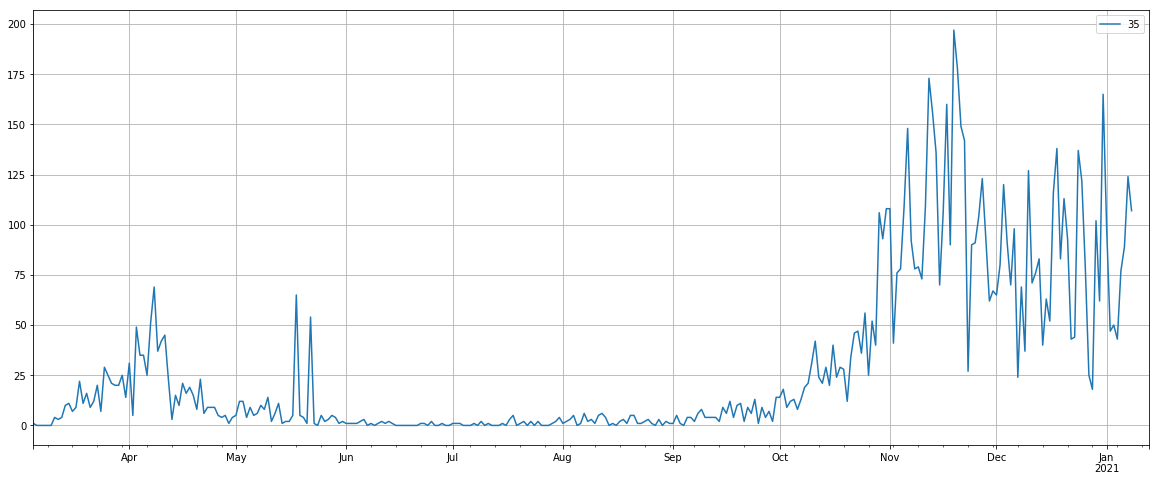

In [3]:
current_directory = os.getcwd()
parent_directory = os.path.split(current_directory)[0]
data = load_data_n_weeks(0, parent_directory + "\\preprocessedLKOS.csv", pad = 5)
data_short = data.iloc[:,35:36] # just Osnabrrücker Land /or Stadt I think
data_short.plot(grid = True, figsize = (20,8))

split_data

In [4]:
def split_data(
    data,
    train_start,
    test_start,
    post_test
):
    """
        split_data(data,data_start,train_start,test_start)

    Utility function that splits the dataset into training and testing data as well as the corresponding target values.

    Returns:
    ========
        data_train:     training data (from beginning of records to end of training phase)
        target_train:   target values for training data
        data_test:      testing data (from beginning of records to end of testing phase = end of records)
        target_test:    target values for testing data
    """

    target_train = data.loc[(train_start <= data.index)
                            & (data.index < test_start)]
    target_test = data.loc[(test_start <= data.index)
                           & (data.index < post_test)]

    data_train = data.loc[data.index < test_start]
    data_test = data

    return data_train, target_train, data_test, target_test


Some default values, same as in original 

In [6]:
current_directory = os.getcwd()
parent_directory = os.path.split(current_directory)[0]
add_info_pd = pd.read_csv(parent_directory + "\\ID_to_name.csv")
additional_info = add_info_pd.to_dict("records")
demographic = add_info_pd["demographic"].to_numpy()

print(demographic)

[ 15753  11519   9248   8477  13829  14653  12655  31230  10070  31825
   6626  13463  11035  10416  46648   9892  23071   4599   2445   3011
  13441   4045   7677   8701   1721   2537   1765   3599   3564   2961
   9412   3870   4621   1759 163913 359130 523043]


Definitions of all features

In [7]:
def spatio_temporal_feature(times, locations):
    _times = [datetime.strptime(d, "%Y-%m-%d") for d in times]
    return np.asarray(_times).reshape((-1, 1)), np.asarray(locations).reshape((1, -1)).astype(np.float32)    

def spatio_temporal_yearly_demographics_feature(locations):
    demographic = 32289 # randomly picked an example value (GMH in 2008)
    return demographic

def temporal_polynomial_feature(t, t0, tmax, order):
    #print(order)
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    tmax = datetime.strptime(tmax, "%Y-%m-%d")

    scale = (tmax - t0).days # (pd.Datetime - pd.Datetime).days -> differenz in tagen (int)
    #print(scale)
    t_delta = (t - t0).days / scale
    #print("delta", t_delta)
    #print( "times order ", t_delta ** order)
    return t_delta ** order
#TemporalFourierFeature(SpatioTemporalFeature)

def temporal_periodic_polynomial_feature(t0, t, period, order):
    # what does period mean? 
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    tdelta = (t-t0).days % period
    return (tdelta / period) ** order
    
def temporal_sigmoid_feature(t0, t, scale):
    # what does scale do here?
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    t_delta = (t - t0) / scale
    return sp.special.expit(t_delta.days + (t_delta.seconds / (3600 * 24)))


def report_delay_polynomial_feature(t0, t, t_max, order):#
    t = datetime.strptime(t, "%Y-%m-%d")
    t0 = datetime.strptime(t0, "%Y-%m-%d")
    t_max = datetime.strptime(t_max, "%Y-%m-%d")
    scale = (t_max - t0).days
    _t = 0 if t <= t0 else (t - t0).days / scale
    return _t ** order

#trange: t0 to tmax
# t0: anfang zeitraum
# t anfang nowcast
# tmax last day foreacast

In [8]:

# What is i, what makes sense for trend_poly_order, periodic_poly_order, report_delay_order?

def features(trange, order, demographic,  include_temporal = True, include_periodic = True, 
             include_demographics = True, include_report_delay = False ):
    #print("features", order)
    trend_poly_order = 1 # as in 
    periodic_poly_order = 4
    report_delay_order = order # What values make sense here??
    feature_collection = {
                "temporal_trend": {
                    "temporal_polynomial_{}".format(i): temporal_polynomial_feature(
                        trange[0], trange[1],trange[2], i
                    )
                    for i in range(trend_poly_order + 1)
                }
                if include_temporal
                else {},
                "temporal_seasonal": {
                    "temporal_periodic_polynomial_{}".format(
                        i
                ): temporal_periodic_polynomial_feature(trange[0],trange[1], 7, i) # why 7
                    for i in range(periodic_poly_order + 1)
                }
                if include_periodic
                else {},


                "temporal_report_delay": {
                    "report_delay": report_delay_polynomial_feature(
                        trange[0],trange[1], trange[2], report_delay_order # 
                    )
                }
                if include_report_delay
                else {},
                "exposure": {
                    "exposure":  demographic * 1.0 / 100000
                }
                ###

    }

    return feature_collection

'''
{'temporal_trend': {'temporal_polynomial_0': 1.0, 'temporal_polynomial_1': -0.75, 'temporal_polynomial_2': 0.5625, 'temporal_polynomial_3': -0.421875}, 
'temporal_seasonal': {'temporal_periodic_polynomial_0': 1.0, 'temporal_periodic_polynomial_1': 0.2857142857142857, 'temporal_periodic_polynomial_2': 0.08163265306122448, 'temporal_periodic_polynomial_3': 0.02332361516034985}, 
'spatiotemporal': {}, 
'temporal_report_delay': {'report_delay': 0.014458261438686257}, 'exposure': {'exposure': 0.32289}}
'''

"\n{'temporal_trend': {'temporal_polynomial_0': 1.0, 'temporal_polynomial_1': -0.75, 'temporal_polynomial_2': 0.5625, 'temporal_polynomial_3': -0.421875}, \n'temporal_seasonal': {'temporal_periodic_polynomial_0': 1.0, 'temporal_periodic_polynomial_1': 0.2857142857142857, 'temporal_periodic_polynomial_2': 0.08163265306122448, 'temporal_periodic_polynomial_3': 0.02332361516034985}, \n'spatiotemporal': {}, \n'temporal_report_delay': {'report_delay': 0.014458261438686257}, 'exposure': {'exposure': 0.32289}}\n"

In [9]:
def datetimeadaptions(date): # I don't like myself for doing this
    year = str(date)[:4] 
    month = str(date)[5:7]
    day = str(date)[8:10]
    return year+"-"+month+"-"+day

def evaluate_features(days, counties, demographic, polynom_order=3):
    #print("evaluate_features" , polynom_order)
    # welches polynom_order
    all_features = pd.DataFrame()
    #print(counties)
    for day in days:

        trange = [datetimeadaptions(day), datetimeadaptions(day+ pd.Timedelta(days=21)), datetimeadaptions(day+ pd.Timedelta(days=31)) ] #first train, beginn nowcast, end forecast

        for i, county in enumerate(counties):

            feature = features(trange, polynom_order, demographic[i], 
                               include_temporal = True, include_periodic = True, include_demographics = True, include_report_delay = True)
            
            feature['date'] = datetimeadaptions(day)
            feature['ID'] = county
            feature_df = pd.DataFrame.from_dict(feature)
            #print(feature_df)
            all_features = all_features.append(feature_df)
    #print("Und hier sind alle features aus evaluate features", all_features)        
    return all_features
            #print(feature)
            # wie sollen die zusammengestackt und sortiert werden?
            # wo sind da irgendwelche Werte drin? die sind ncoh alle gleich
    

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [34]:
def get_features(target, demographics, poly_order = 3):
    
    days, counties = target.index, target.columns
    # extract features
    
    all_features = evaluate_features(days, counties, demographics,  polynom_order = poly_order)
    
    all_features.astype(float, errors = 'ignore')
    #print(all_features)
    Y_obs = target.stack().values.astype(np.float32)
    
    len_targets = len(days) * len(counties)
    
    T_S = all_features.filter(regex = "temporal_periodic_polynomial_\d", axis = 0).dropna(axis = 1)#.values.astype(np.float32) #features["temporal_seasonal"].values.astype(np.float32)
    T_S = T_S.sort_values(["date", "ID"])
    #print("This is T_S \n")
    #print(T_S)
    T_S = T_S['temporal_seasonal'].to_numpy()

    T_S = T_S.reshape(len_targets, -1)
    
    T_T = all_features.filter(regex = "temporal_polynomial_\d", axis = 0).dropna(axis = 1) #features["temporal_trend"].values.astype(np.float32)
    T_T = T_T.sort_values([ "date","ID"])
    T_T = T_T["temporal_trend"].to_numpy()
    T_T = T_T.reshape(len_targets, -1)
    
    T_D = all_features.filter(regex = "report_delay", axis = 0).dropna(axis = 1) #features["temporal_report_delay"].values.astype(np.float32)
    T_D = T_D.sort_values(["date", "ID"])
    T_D = T_D["temporal_report_delay"].to_numpy()
    T_D = T_D.reshape(len_targets, -1)
    
    exposure = all_features.filter(regex = "exposure", axis = 0).dropna(axis = 1) #features["spatiotemporal"].values.astype(np.float32)
    exposure = exposure.sort_values(["date", "ID"])
    exposure = exposure["exposure"].to_numpy()
    exposure = exposure.reshape(len_targets, -1)
    # has to be sorted I guess? order matches the one of Y_obs =) 
    return [Y_obs, T_S, T_T, T_D, exposure]

In [35]:
 # Default Values
number_of_weeks = 3
days_into_future = 5
start = 180
start_date = pd.Timestamp("2020-03-20") + pd.Timedelta(days=start)


csv_path = parent_directory + "\\preprocessedLKOS.csv"

# should move this further down
num_chains = 2 
num_cores = num_chains
trend_order = 1 # ? 
periodic_order = 4 # ??
use_report_delay = True # ?
use_demographics = True #? 
   


In [36]:
data = load_data_n_weeks(start, csv_path, pad=days_into_future)
data = data.iloc[:,35:36]
data
demographic_selection = demographic[35:36]


C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [37]:

# According to OC (Original Code) For the simple model, only targets are required 
data_train, target_train, data_test, target_test = split_data(
    data,
    train_start=start_date,
    # test_start=last_day - pd.Timedelta(days=days_into_future+4),
    test_start=start_date + pd.Timedelta(days=number_of_weeks * 7),
    post_test=start_date + pd.Timedelta(days=number_of_weeks * 7 + 10),
)


tspan = (target_train.index[0], target_train.index[-1])
#print("CHECK")
#print(start)
#print(start_date)
#print(tspan)
print(target_train)

              35
2020-09-16   6.0
2020-09-17  12.0
2020-09-18   4.0
2020-09-19  10.0
2020-09-20  11.0
2020-09-21   2.0
2020-09-22   9.0
2020-09-23   6.0
2020-09-24  13.0
2020-09-25   1.0
2020-09-26   9.0
2020-09-27   4.0
2020-09-28   7.0
2020-09-29   2.0
2020-09-30  14.0
2020-10-01  14.0
2020-10-02  18.0
2020-10-03   9.0
2020-10-04  12.0
2020-10-05  13.0
2020-10-06   8.0


In [38]:
def model(features, data):
    target = features[0]
    #print(target)
    T_S = features[1] 
    T_T = features[2] 
    T_D = features[3] 
    exposure = features[4]
    days, counties = data.index, data.columns
    
    log_exposure = np.log(exposure).astype(np.float32).ravel()
    num_obs = np.prod(target.shape)
    num_t_s = T_S.shape[1]
    num_t_t = T_T.shape[1]
    num_t_d = T_D.shape[1]
    #num_ts = TS.shape[1]
    num_counties = len(counties)
    with pm.Model() as model:
        # priors
        # δ = 1/√α
        δ = pm.HalfCauchy("δ", 10, testval=1.0)
        α = pm.Deterministic("α", np.float32(1.0) / δ)

        W_t_s = pm.Normal(
            "W_t_s", mu=0, sd=10, testval=np.zeros(num_t_s), shape=num_t_s
        )
        W_t_t = pm.Normal(
            "W_t_t",
            mu=0,
            sd=10,
            testval=np.zeros((num_counties, num_t_t)),
            shape=(num_counties, num_t_t),
        )

        W_t_d = pm.Normal(
            "W_t_d", mu=0, sd=10, testval=np.zeros(num_t_d), shape=num_t_d
        )
#         W_ts = pm.Normal(
#             "W_ts", mu=0, sd=10, testval=np.zeros(num_ts), shape=num_ts
#         )

        param_names = ["δ", "W_t_s", "W_t_t", "W_t_d"]#, "W_ts"]
        params = [δ, W_t_s, W_t_t, W_t_d]#, W_ts]

        expanded_Wtt = tt.tile(
            W_t_t.reshape(shape=(1, num_counties, -1)), reps=(21, 1, 1)
        )
        expanded_TT = np.reshape(T_T, newshape=(21, num_counties, 2)) # was 21, num_counties, 2 (why two? Why 4? )
        result_TT = tt.flatten(tt.sum(expanded_TT * expanded_Wtt, axis=-1))

        # calculate mean rates
        μ = pm.Deterministic(
            "μ",
            tt.exp(
                tt.dot(T_S, W_t_s)
                + result_TT
                + tt.dot(T_D, W_t_d)
                #+ tt.dot(TS, W_ts)
                + log_exposure
            ),
        )
        # constrain to observations
        pm.NegativeBinomial("Y", mu=μ, alpha=α, observed=target)
    return model

In [39]:
features_for_model = get_features(target_train, demographic_selection)


In [40]:
model = model(features_for_model, target_train)
#trace = sample_model(model)

In [41]:
def sample_parameters(
        target,
        n_init=100,
        samples=1000,
        chains=2,
        init="advi",
        target_accept=0.8, #was 0.8
        max_treedepth=12, #was 10
        cores = 1,
        **kwargs
    ):
        """
            sample_parameters(target, samples=1000, cores=8, init="auto", **kwargs)

        Samples from the posterior parameter distribution, given a training dataset.
        The basis functions are designed to be causal, i.e. only data points strictly
        predating the predicted time points are used (this implies "one-step-ahead"-predictions).
        """

        #self.init_model(target)

        
        with model:
            # run!
            nuts = pm.step_methods.NUTS(
                #vars= params,
                target_accept=target_accept,
                max_treedepth=max_treedepth,
            )
            trace = pm.sample(
                samples,
                nuts,
                chains=chains,
                cores=cores,
                compute_convergence_checks=False,
                **kwargs
            )
        return trace

In [42]:
trace = sample_parameters(target_train)

Sequential sampling (2 chains in 1 job)
NUTS: [W_t_d, W_t_t, W_t_s, δ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 212 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6930766088790696, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\plots\traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (31), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3A77AD288>,
      dtype=object)

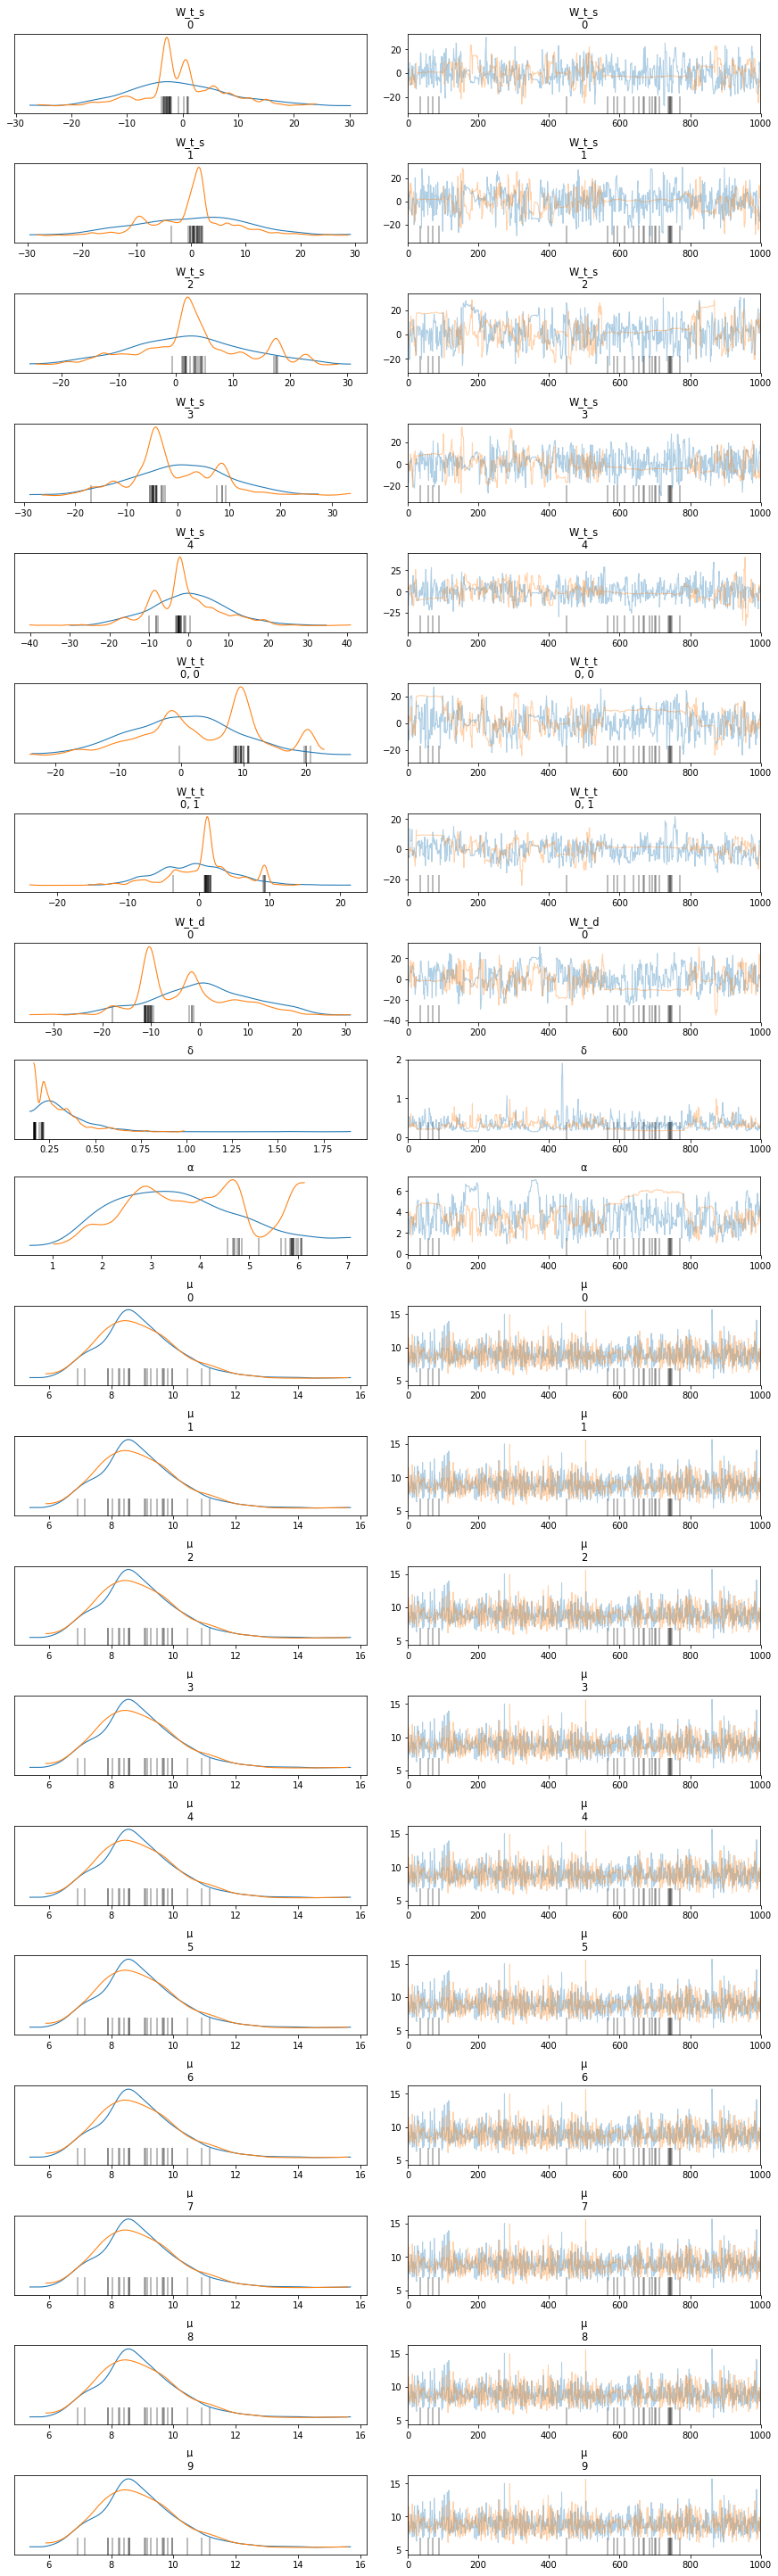

In [43]:
az.plot_trace(trace)
#plt.savefig("Trace2.png")

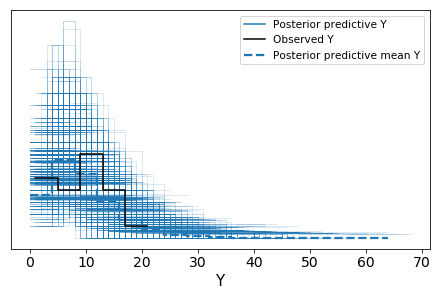

In [44]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace    )
# "δ", "W_t_s", "W_t_t", "W_t_d"
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));
#plt.savefig("Sample_Posterior_Predictive.png")

In [22]:
np.exp(az.summary(trace)[["mean", "hdi_3%", "hdi_97%"]])

C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,hdi_3%,hdi_97%
W_t_s[0],0.972388,8.587141e-09,2.891873e+07
"W_t_t[0,0]",2.155451,5.466731e-08,6.875087e+07
"W_t_t[0,1]",0.905743,3.472676e-05,2.618652e+04
W_t_d[0],0.840297,4.887499e-08,7.689874e+07
δ,1.378506,1.119632e+00,1.820298e+00
α,42.393710,3.636421e+00,7.119445e+02
μ[0],7115.280973,6.220373e+02,6.894056e+04
μ[1],7115.280973,6.220373e+02,6.894056e+04
μ[2],7115.280973,6.220373e+02,6.894056e+04
μ[3],7115.280973,6.220373e+02,6.894056e+04


In [57]:
def sample_predictions(
    target_days_counties,
    demographics,
    parameters,
    prediction_days,
    average_periodic_feature=False,
    average_all=False,
    init="auto",
):
    

    target_days = target_days_counties.index
    #print("Target days", target_days)
    target_counties = target_days_counties.columns
    num_counties = len(target_counties) # check this again

    all_days = target_days.append(prediction_days)
    #print(all_days)
    all_days_counties = pd.DataFrame(index = all_days, columns = target_counties)

    # extract features
    features_ = get_features(all_days_counties, demographics)
    target = features_[0]
    #print(target)
    T_S = features_[1] 
    T_T = features_[2] 
    T_D = features_[3]

    exposure = features_[4]
    
    log_exposure = np.log(exposure).astype(np.float32).ravel()
 

    if average_periodic_feature:
        T_S = np.reshape(T_S, newshape=(-1, num_counties, 5))
        mean = np.mean(T_S, axis=0, keepdims=True)
        T_S = np.reshape(np.tile(mean, reps=(T_S.shape[0], 1, 1)), (-1, 5))

    if average_all:
        T_S = np.reshape(T_S, newshape=(31, num_counties, -1))
        mean = np.mean(T_S, axis=0, keepdims=True)
        T_S = np.reshape(np.tile(mean, reps=(31, 1, 1)), (-1, 5))

        T_D = np.reshape(T_D, newshape=(31, num_counties, -1))
        mean = np.mean(T_D, axis=0, keepdims=True)
        T_D = np.reshape(np.tile(mean, reps=(31, 1, 1)), (-1))

        log_exposure = np.reshape(log_exposure, newshape=(31, num_counties))
        mean = np.mean(log_exposure, axis=0, keepdims=True)
        log_exposure = np.reshape(np.tile(mean, reps=(31, 1)), (-1))

    # extract coefficient samples
    α = parameters["α"]
    W_t_s = parameters["W_t_s"]
    W_t_t = parameters["W_t_t"]
    W_t_d = parameters["W_t_d"]
    #W_ts = parameters["W_ts"]

   
    num_predictions = len(target_days) * len(target_counties) + len(
        prediction_days
    ) * len(target_counties)
    num_parameter_samples = α.size
    print("Num_paramter_samples", num_parameter_samples)
    y = np.zeros((num_parameter_samples, num_predictions), dtype=int)
    μ = np.zeros((num_parameter_samples, num_predictions), dtype=np.float32)

    expanded_Wtt = np.tile(
        np.reshape(W_t_t, newshape=(-1, 1, num_counties, 2)), reps=(1, 31, 1, 1)
    )

    expanded_TT = np.reshape(T_T, newshape=(1, 31, num_counties, 2))
    result_TT = np.reshape(
        np.sum(expanded_TT * expanded_Wtt, axis=-1), newshape=(-1, 31 * num_counties)
    )

    # NOTE: the delay polynomial is left out here!
    # mean_delay /= num_parameter_samples
    print("1: \n")
    print(np.dot(T_S, W_t_s[0]))
    print("2: \n")
    print(result_TT[0])
    print("3: \n")
    print(T_D)
    print("4: \n")
    print(W_t_d[0])
    print("5: \n")
    print(log_exposure)
    
    for i in range(num_parameter_samples):
        print(i, "/", num_parameter_samples)
        μ[i, :] = np.exp( #why exp?
            np.dot(T_S, W_t_s[i])
            + result_TT[i]
            #+ np.dot(TS, W_ts[i])
            + np.dot(T_D, W_t_d[i])
            + log_exposure 
        )
        y[i, :] = pm.NegativeBinomial.dist(mu=μ[i, :], alpha=α[i]).random()
    print("y", y, "μ", μ, "α", α)
    return {"y": y, "μ": μ, "α": α}

In [50]:
pred = sample_predictions(
        target_train,
        demographic_selection, 
        trace,
        target_test.index,
        average_periodic_feature=False,
        average_all=False,
    )

Num_paramter_samples 2000
0 / 2000
1 / 2000
2 / 2000
3 / 2000
4 / 2000
5 / 2000
6 / 2000
7 / 2000
8 / 2000
9 / 2000
10 / 2000
11 / 2000
12 / 2000
13 / 2000
14 / 2000
15 / 2000
16 / 2000
17 / 2000
18 / 2000
19 / 2000
20 / 2000
21 / 2000
22 / 2000
23 / 2000
24 / 2000
25 / 2000
26 / 2000
27 / 2000
28 / 2000
29 / 2000
30 / 2000
31 / 2000
32 / 2000
33 / 2000
34 / 2000
35 / 2000
36 / 2000
37 / 2000
38 / 2000
39 / 2000
40 / 2000
41 / 2000
42 / 2000
43 / 2000
44 / 2000
45 / 2000
46 / 2000
47 / 2000
48 / 2000
49 / 2000
50 / 2000
51 / 2000
52 / 2000
53 / 2000
54 / 2000
55 / 2000
56 / 2000
57 / 2000
58 / 2000
59 / 2000
60 / 2000
61 / 2000
62 / 2000
63 / 2000
64 / 2000
65 / 2000
66 / 2000
67 / 2000
68 / 2000
69 / 2000
70 / 2000
71 / 2000
72 / 2000
73 / 2000
74 / 2000
75 / 2000
76 / 2000
77 / 2000
78 / 2000
79 / 2000
80 / 2000
81 / 2000
82 / 2000
83 / 2000
84 / 2000
85 / 2000
86 / 2000
87 / 2000
88 / 2000
89 / 2000
90 / 2000
91 / 2000
92 / 2000
93 / 2000
94 / 2000
95 / 2000
96 / 2000
97 / 2000
98 /

In [32]:
with open("predictions", "wb") as f:
    pkl.dump(pred, f)
# with open("predictions_trend", "wb") as f:
#     pkl.dump(pred_trend, f)
with open("trace", "wb") as f:
    pkl.dump(trace, f)
with open("model", "wb") as f:
    pkl.dump(model, f)

In [58]:
pred_trend = sample_predictions(
    target_train,
    demographic_selection,
    trace,
    target_test.index,
    average_periodic_feature=False,
    average_all=True,
)

Num_paramter_samples 2000
1: 

[-0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406
 -0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406
 -0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406
 -0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406
 -0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406 -0.52937406
 -0.52937406]
2: 

[3.31939767 3.31939767 3.31939767 3.31939767 3.31939767 3.31939767
 3.31939767 3.31939767 3.31939767 3.31939767 3.31939767 3.31939767
 3.31939767 3.31939767 3.31939767 3.31939767 3.31939767 3.31939767
 3.31939767 3.31939767 3.31939767 3.31939767 3.31939767 3.31939767
 3.31939767 3.31939767 3.31939767 3.31939767 3.31939767 3.31939767
 3.31939767]
3: 

[0.3108657 0.3108657 0.3108657 0.3108657 0.3108657 0.3108657 0.3108657
 0.3108657 0.3108657 0.3108657 0.3108657 0.3108657 0.3108657 0.3108657
 0.3108657 0.3108657 0.3108657 0.3108657 0.3108657 0.3108657 0.3108657
 0.3108657 0.310865

ValueError: shapes (31,) and (1,) not aligned: 31 (dim 0) != 1 (dim 0)

In [ ]:
def load_trace(start, n_weeks):
    filename = "../data/mcmc_samples_backup/parameters_covid19_{}".format(start)
    model = load_model(start, n_weeks)
    with model:
        trace = pm.load_trace(filename)
    del model
    return trace

def load_model(start, n_weeks):
    filename = "../data/mcmc_samples_backup/model_covid19_{}.pkl".format(start)
    with open(filename, "rb") as f:
        model = pkl.load(f)
    return model

def load_predictions(start, n_weeks):
    filename = "../data/mcmc_samples_backup/predictions_covid19_{}.pkl".format(start)
    with open(filename, "rb") as f:
        res = pkl.load(f)
    return res

def load_trend_predictions(start, n_weeks):
    filename = "../data/mcmc_samples_backup/predictions_trend_covid19_{}.pkl".format(start)
    with open(filename, "rb") as f:
        res = pkl.load(f)
    return res

In [ ]:
current_directory = os.getcwd()
parent_directory = os.path.split(current_directory)[0]
csv_file = parent_directory + "\\preprocessedLKOS.csv" 

In [ ]:
#def plotdata_csv(start, n_weeks, csv_path, counties, output_dir):
#countyByName = make_county_dict()

# are defined in the beginning
# number_of_weeks = 3
n_weeks = 3
# days_into_future = 5
# start = 120
# start_date = pd.Timestamp("2020-03-20") + pd.Timedelta(days=start)


data = load_data_n_weeks(start, csv_path, pad=days_into_future)
data = data.iloc[:,34:36]
data


#data = load_data_n_weeks(start, n_weeks, csv_path)
start_day = pd.Timestamp("2020-03-05") + pd.Timedelta(days=start)
day_0 = start_day + pd.Timedelta(days=n_weeks * 7 + 5)
day_m5 = day_0 - pd.Timedelta(days=5)
day_p5 = day_0 + pd.Timedelta(days=5)
_, target, _, _ = split_data(
    data, train_start=start_day, test_start=day_0, post_test=day_p5
)

# Load our prediction samples
res = pred #load_predictions(start, n_weeks)
#res_trend = load_trend_predictions(start, n_weeks)

prediction_samples = np.reshape(res["y"], (res["y"].shape[0], -1, 412))
prediction_samples_mu = np.reshape(res["μ"], (res["μ"].shape[0], -1, 412))
# prediction_samples_trend = np.reshape(
#     res_trend["y"], (res_trend["y"].shape[0], -1, 412)
# )
# prediction_samples_trend_mu = np.reshape(
#     res_trend["μ"], (res_trend["μ"].shape[0], -1, 412)
# )
# predictions_7day_inc = sample_x_days_incidence_by_county(
#     prediction_samples_trend, 7
# )
# predictions_7day_inc_mu = sample_x_days_incidence_by_county(
#     prediction_samples_trend_mu, 7
# )
ext_index = pd.DatetimeIndex(
    [d for d in target.index]
    + [
        d
        for d in pd.date_range(
            target.index[-1] + timedelta(1), day_p5 - timedelta(1)
        )
    ]
)

prediction_quantiles = np.quantile(prediction_samples, (0.5, 0.25, 0.75, 0.95))
#prediction_quantiles_trend = np.quantile(prediction_samples_trend, (0.5, 0.25, 0.75, 0.95))
#prediction_quantiles_7day_inc = np.quantile(predictions_7day_inc, (0.5, 0.25, 0.75, 0.95))

prediction_mean = pd.DataFrame(
    data=np.mean(prediction_samples_mu, axis=0),
    index=ext_index,
    columns=target.columns,
)
prediction_q25 = pd.DataFrame(
    data=prediction_quantiles[25], index=ext_index, columns=target.columns
)
prediction_q75 = pd.DataFrame(
    data=prediction_quantiles[75], index=ext_index, columns=target.columns
)
prediction_q5 = pd.DataFrame(
    data=prediction_quantiles[5], index=ext_index, columns=target.columns
)
prediction_q95 = pd.DataFrame(
    data=prediction_quantiles[95], index=ext_index, columns=target.columns
)

# prediction_mean_trend = pd.DataFrame(
#     data=np.mean(prediction_samples_trend_mu, axis=0),
#     index=ext_index,
#     columns=target.columns,
# )
# prediction_q25_trend = pd.DataFrame(
#     data=prediction_quantiles_trend[25], index=ext_index, columns=target.columns
# )
# prediction_q75_trend = pd.DataFrame(
#     data=prediction_quantiles_trend[75], index=ext_index, columns=target.columns
# )
# prediction_q5_trend = pd.DataFrame(
#     data=prediction_quantiles_trend[5], index=ext_index, columns=target.columns
# )
# prediction_q95_trend = pd.DataFrame(
#     data=prediction_quantiles_trend[95], index=ext_index, columns=target.columns
# )

# prediction_mean_7day = pd.DataFrame(
#     data=np.pad(
#         np.mean(predictions_7day_inc_mu, axis=0),
#         ((7, 0), (0, 0)),
#         "constant",
#         constant_values=np.nan,
#     ),
#     index=ext_index,
#     columns=target.columns,
# )
# prediction_q25_7day = pd.DataFrame(
#     data=np.pad(
#         prediction_quantiles_7day_inc[25].astype(float),
#         ((7, 0), (0, 0)),
#         "constant",
#         constant_values=np.nan,
#     ),
#     index=ext_index,
#     columns=target.columns,
# )
# prediction_q75_7day = pd.DataFrame(
#     data=np.pad(
#         prediction_quantiles_7day_inc[75].astype(float),
#         ((7, 0), (0, 0)),
#         "constant",
#         constant_values=np.nan,
#     ),
#     index=ext_index,
#     columns=target.columns,
# )
# prediction_q5_7day = pd.DataFrame(
#     data=np.pad(
#         prediction_quantiles_7day_inc[5].astype(float),
#         ((7, 0), (0, 0)),
#         "constant",
#         constant_values=np.nan,
#     ),
#     index=ext_index,
#     columns=target.columns,
# )
# prediction_q95_7day = pd.DataFrame(
#     data=np.pad(
#         prediction_quantiles_7day_inc[95].astype(float),
#         ((7, 0), (0, 0)),
#         "constant",
#         constant_values=np.nan,
#     ),
#     index=ext_index,
#     columns=target.columns,
# )

rki_7day = target.rolling(7).sum()

ref_date = target.iloc[-1].name
nowcast_vals = prediction_mean.loc[prediction_mean.index == ref_date]
nowcast7day_vals = prediction_mean_7day.loc[prediction_mean.index == ref_date]
rki_vals = target.iloc[-1]
rki_7day_vals = rki_7day.iloc[-1]

map_nowcast = []
map_nowcast100k = []
map_nowcast_7day = []
map_nowcast_7day100k = []
map_rki = []
map_rki100k = []
map_rki_7day = []
map_rki_7day100k = []
map_keys = []

for (county, county_id) in countyByName.items():
    rki_data = np.append(target.loc[:, county_id].values, np.repeat(np.nan, 5))
    rki_data7day = np.append(
        rki_7day.loc[:, county_id].values, np.repeat(np.nan, 5)
    )
    n_people = counties[county_id]["demographics"][("total", 2018)]

    map_nowcast.append(nowcast_vals[county_id].item())
    map_nowcast100k.append(nowcast_vals[county_id].item() / n_people * 100000)
    map_nowcast_7day.append(nowcast7day_vals[county_id].item())
    map_nowcast_7day100k.append(
        nowcast7day_vals[county_id].item() / n_people * 100000
    )
    map_rki.append(rki_vals[county_id].item())
    map_rki100k.append(rki_vals[county_id].item() / n_people * 100000)
    map_rki_7day.append(rki_7day_vals[county_id].item())
    map_rki_7day100k.append(rki_7day_vals[county_id].item() / n_people * 100000)
    map_keys.append(county_id)

    county_data = pd.DataFrame(
        {
            "Raw Prediction Mean": prediction_mean.loc[:, county_id].values,
            "Raw Prediction Mean 100k": np.multiply(
                np.divide(prediction_mean.loc[:, county_id].values, n_people),
                100000,
            ),
            "Raw Prediction Q25": prediction_q25.loc[:, county_id].values,
            "Raw Prediction Q25 100k": np.multiply(
                np.divide(prediction_q25.loc[:, county_id].values, n_people),
                100000,
            ),
            "Raw Prediction Q75": prediction_q75.loc[:, county_id].values,
            "Raw Prediction Q75 100k": np.multiply(
                np.divide(prediction_q75.loc[:, county_id].values, n_people),
                100000,
            ),
            "Raw Prediction Q5": prediction_q5.loc[:, county_id].values,
            "Raw Prediction Q5 100k": np.multiply(
                np.divide(prediction_q5.loc[:, county_id].values, n_people), 100000,
            ),
            "Raw Prediction Q95": prediction_q95.loc[:, county_id].values,
            "Raw Prediction Q95 100k": np.multiply(
                np.divide(prediction_q95.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Mean": prediction_mean_trend.loc[:, county_id].values,
            "Trend Prediction Mean 100k": np.multiply(
                np.divide(prediction_mean_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Q25": prediction_q25_trend.loc[:, county_id].values,
            "Trend Prediction Q25 100k": np.multiply(
                np.divide(prediction_q25_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Q75": prediction_q75_trend.loc[:, county_id].values,
            "Trend Prediction Q75 100k": np.multiply(
                np.divide(prediction_q75_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Q5": prediction_q5_trend.loc[:, county_id].values,
            "Trend Prediction Q5 100k": np.multiply(
                np.divide(prediction_q5_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend Prediction Q95": prediction_q95_trend.loc[:, county_id].values,
            "Trend Prediction Q95 100k": np.multiply(
                np.divide(prediction_q95_trend.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Mean": prediction_mean_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Mean 100k": np.multiply(
                np.divide(prediction_mean_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Q25": prediction_q25_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Q25 100k": np.multiply(
                np.divide(prediction_q25_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Q75": prediction_q75_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Q75 100k": np.multiply(
                np.divide(prediction_q75_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Q5": prediction_q5_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Q5 100k": np.multiply(
                np.divide(prediction_q5_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "Trend 7Week Prediction Q95": prediction_q95_7day.loc[
                :, county_id
            ].values,
            "Trend 7Week Prediction Q95 100k": np.multiply(
                np.divide(prediction_q95_7day.loc[:, county_id].values, n_people),
                100000,
            ),
            "RKI Meldedaten": rki_data,
            "RKI 7Day Incidence": rki_data7day,
            "is_nowcast": (day_m5 <= ext_index) & (ext_index < day_0),
            "is_high": np.less(
                prediction_q95_trend.loc[:, county_id].values, rki_data
            ),
            "is_prediction": (day_0 <= ext_index),
        },
        index=ext_index,
    )
    fpath = os.path.join(output_dir, "{}.csv".format(countyByName[county]))
    county_data.to_csv(fpath)

map_df = pd.DataFrame(index=None)
map_df["countyID"] = map_keys
map_df["newInf100k"] = map_nowcast100k
map_df["7DayInf100k"] = map_nowcast_7day100k
map_df["newInf100k_RKI"] = map_rki100k
map_df["7DayInf100k_RKI"] = map_rki_7day100k
map_df["newInfRaw"] = map_nowcast
map_df["7DayInfRaw"] = map_nowcast_7day
map_df["newInfRaw_RKI"] = map_rki
map_df["7DayInfRaw_RKI"] = map_rki_7day
map_df.to_csv(os.path.join(output_dir, "map.csv"))